# Model Analysis Notebook

The purpose of this notebook is to analyze how multimodal learning has affected our weights. This is different than evaluation on the final generated lyrics. Instead, here we focus of if the features we implemented have "moved the needle" in terms of the distribution of the next word.

This notebook is meant to be run after the model fitting notebooks. Thus, we will ignore any data collection processes, making the assumption that these have already been executed in the modeling notebooks.

In [1]:
%load_ext autoreload

In [2]:
%autoreload

In [3]:
import pandas as pd
import numpy as np
import nltk.tokenize
import itertools
import datetime
import torch

from pathlib import Path

from fastai import *
from fastai.text import *

from copy import copy, deepcopy
from enum import Enum

from graphviz import Digraph

import datetime

from sklearn.preprocessing import StandardScaler
from src.data_collection.multimodal_data import *

from tqdm import tqdm

#### Function to Generate Text For Pure LM

Implementing a `get_probs` option for text generation. For this method, generate a shorter sequence of text with a very wide beam. Then, will perform a bag of words analysis across different models

In [4]:
def generate_step(learner, context, context_length, temp=1):

    model = learner.model
    
    if GPU:
        context = LongTensor(context[-context_length:]).view(-1,1).cuda()
    else:
        context = LongTensor(context[-context_length:]).view(-1,1).cpu()
    
    context = torch.autograd.Variable(context)
    
    model.reset()
    model.eval()
        
    # forward pass the "context" into the model
    result, *_ = model(context)
    result = result[-1]

    # set unk and pad to 0 prob
    # i.e. never pick unknown or pad
    result[0] = -np.inf
    result[1] = -np.inf

    # softmax and normalize
    probabilities = F.softmax(result/temp, dim=0)
    probabilities = np.asarray(probabilities.detach().cpu(), dtype=np.float)
    probabilities /= np.sum(probabilities) 
    return probabilities

def get_word_from_index(idx):

    return data_lm.valid_ds.vocab.textify([idx])


def print_words(context):
    for i in range(len(context)):
        
        step = context[i]

        word = data_lm.valid_ds.vocab.textify([step])

        if word == 'xeol':
            word = 'xeol \n'
        elif 'xbol' in word:
            word = word
        elif word == 'xeos': 
            print(word)
            break
            
        print(word, end=' ')   

def generate_text(learner, seed_text=['xbos'],
                  max_len=500, GPU=False, context_length=20,
                  beam_width=5, temp=1, multinomial=True,
                  verbose=True, graph=False, get_probs=False):
    """Generates text with a given learner and returns best options.

    Parameters
    ----------
    learner : RNNLearner Language Model (RNNLearner.language_model())
        Fastai RNNLearner with tokenized language model data already loaded 
        
    seed_text : list or str
        List of strings where each item is a token. (e.g. ['the', 'cat']) or string that is split on white space

    max_len : int
        Number of words in generated sequence
        
    gpu : bool
        If you're using a GPU or not...
    
    context_length : int
        Amount of words that get input as "context" into the model. Set to 0 for no limit   
        
    beam_width : int
        How many new word indices to try out...computationally expensive
    
    verbose : bool
        If True, prints every possible context for a given word cycle

    Returns
    -------
    context_and_scores : list of lists
        Returns a sorted list of the entire tree search of contexts and their respective scores in the form:
        [[context, score], [context, score], ..., [context, score]]
    """
        
    if isinstance(seed_text, str):
        seed_text = data_lm.train_ds.vocab.numericalize(seed_text.split(' '))
    
    
    # Width for the beam search, to be externalized along with general decoding
    beam_width = beam_width
    
    if graph:
        optimization_graph = Digraph()

    # List of candidate word sequence. We'll maintain #beam_width top sequences here.
    # The context is a list of words, the scores are the sum of the log probabilities of each word
    context_and_scores = [[seed_text, 0.0]]
    
    # Loop over max number of words
    for word_number in tqdm(range(max_len)):
#         print(f'Generating word: {word_number+1} / {max_len}')

        candidates = []
        next_word_probs = []
        
        # For each possible context that we've generated so far, generate new probabilities, 
        # and pick an additional #beam_width next candidates
        for i in range(len(context_and_scores)):
            # Get a new sequence of word indices and log-probability
            # Example: [[2, 138, 661], 23.181717]
            context, score = context_and_scores[i]
            
            # Obtain probabilities for next word given the context 
            probabilities = generate_step(learner, context, context_length, temp)

            # Multinomial draw from the probabilities
            if multinomial:
                multinom_draw = np.random.multinomial(beam_width, probabilities)
                top_probabilities = np.argwhere(multinom_draw != 0).flatten()                    
                
            # top-k from probabilities    
            else:
                top_probabilities = np.argsort(-probabilities)[:beam_width]
                        
            #For each possible new candidate, update the context and scores
            for j in range(len(top_probabilities)):
                next_word_idx = top_probabilities[j]
                new_context = context + [next_word_idx]
                candidate = [new_context, (score - np.log(probabilities[next_word_idx]))]
                candidates.append(candidate)
                
                if get_probs:
                    next_word_prob = probabilities[next_word_idx]
                    potential_next_word = get_word_from_index(next_word_idx)
                    prior_context = [get_word_from_index(w) for w in context]
                    next_word_probs.append((prior_context, potential_next_word, next_word_prob))
                
                if graph:
                    optimization_graph.node("%d_%d" % (word_number, next_word_idx), "%s (%.2f)" % (get_word_from_index(next_word_idx), candidate[1]))
                    optimization_graph.edge("%d_%d" % (word_number - 1, context[len(context) -1]), "%d_%d" % (word_number, next_word_idx))
                
        #update the running tally of context and scores and sort by probability of each entry
        context_and_scores = candidates
        context_and_scores = sorted(context_and_scores, key = lambda x: x[1]) #sort by top entries

        context_and_scores = context_and_scores[:30] #for now, only keep the top 30 to speed things up but we can/should change this to beam_width or something else
        
        if verbose:
            for context, score in context_and_scores:
                print_words(context)
                print('\n')

    if graph:
        now = str(datetime.datetime.now())
        optimization_graph.render(directory='graph_viz/', filename=now, cleanup=True)
        
    if get_probs:
        next_word_probs = sorted(next_word_probs, key=lambda x: -x[2])
        return next_word_probs
        
    return context_and_scores
    

#### Import stopwords and add my own

In [5]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/syang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
stop_words = set(stopwords.words('english')) 
stop_words.add("'t")
stop_words.add("'ll")
stop_words.add("’t")
stop_words.add("'ve")
stop_words.add(",")
stop_words.add("'s")
stop_words.add("'re")
stop_words.add("'m")
stop_words.add("don")
stop_words.add("won")
stop_words.add("xbol")
stop_words.add("xbos")
stop_words.add("xeol")
stop_words.add("xeos")

In [7]:
GPU=True

## Pure Language Model (3.2-ULMFiT-108k)
* Transfer learning from wikitext-103 to 108k corpus

In [375]:
MODEL_PATH = Path(f'../data/models/3.2-ULMFiT-108k')

In [376]:
data_lm = TextLMDataBunch.from_tokens(MODEL_PATH,
                                      bs=128,
                                      max_vocab=10000)

In [377]:
data_lm.train_ds.vocab.itos[:10]

['xxunk', 'xxpad', 'xbol', 'xeol', ',', 'i', 'the', 'you', 'to', 'and']

In [378]:
learn = RNNLearner.language_model(data_lm,
                                  pretrained_fnames=['3.2-ULMFiT-108k_best',
                                                     '3.2-ULMFiT-108k_itos'],
                                  drop_mult=0.5)

In [379]:
next_word_probs = generate_text(learn, GPU=GPU,
                             seed_text='xbos xbol [verse-1] xeol xbol',
                             max_len=2, context_length=200,
                             beam_width=1000, verbose=False,
                             temp=1, multinomial=False, graph=False, get_probs=True)

100%|██████████| 2/2 [00:00<00:00,  2.64it/s]


In [380]:
next_word_probs = [s for s in next_word_probs if s[1] not in stop_words]

In [381]:
df = pd.DataFrame(next_word_probs, columns=['context', 'next_word', 'probability'])
df.head(10)

,context,next_word,probability
0,"[xbos, xbol, [verse-1], xeol, xbol, one]",day,0.290520
1,"[xbos, xbol, [verse-1], xeol, xbol, no]",one,0.241687
2,"[xbos, xbol, [verse-1], xeol, xbol, they]",say,0.168200
3,"[xbos, xbol, [verse-1], xeol, xbol, here]",comes,0.165289
4,"[xbos, xbol, [verse-1], xeol, xbol, how]",many,0.128627
5,"[xbos, xbol, [verse-1], xeol, xbol, my]",heart,0.094780
6,"[xbos, xbol, [verse-1], xeol, xbol, so]",many,0.085646
7,"[xbos, xbol, [verse-1], xeol, xbol, how]",long,0.074577
8,"[xbos, xbol, [verse-1], xeol, xbol, no]",matter,0.071768
9,"[xbos, xbol, [verse-1], xeol, xbol, one]",night,0.071546


In [382]:
df.groupby('next_word').sum().sort_values(by='probability', ascending=False)

,probability
next_word,
day,3.362332e-01
one,2.910156e-01
many,2.176971e-01
say,2.010951e-01
said,2.009788e-01
comes,1.932980e-01
love,1.732307e-01
time,1.673621e-01
heart,1.511759e-01


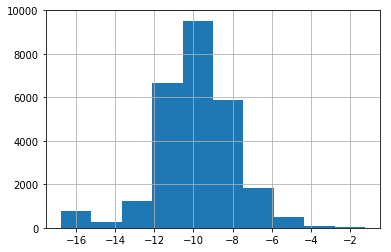

In [383]:
np.log(df['probability']).hist()
plt.show()

In [384]:
final_scores = generate_text(learn, GPU=GPU,
                             seed_text='xbos xbol [verse-1] xeol xbol',
                             max_len=50, context_length=200,
                             beam_width=3, verbose=False,
                             temp=1.4, multinomial=True, graph=False, get_probs=False)

100%|██████████| 50/50 [00:29<00:00,  1.09it/s]


In [385]:
#print all of the final options of songs
song, score = final_scores[0]
print_words(song)
print(score)

xbos xbol [verse-1] xeol 
 xbol inside my head there 's something unsaid xeol 
 xbol i 'm down on my knees to keep someone next to me xeol 
 xbol and i don 't know when or why xeol 
 xbol i don 't care what it 's all about xeol 
 xbol xeol 
 xbol [pre-chorus] xeol 
 xbol i 115.52940888716925


## Pure Language Model (3.3-ULMFiT-108k)
* Transfer learning from model 3.2 to 500k corpus
* Transfer learning from 500k corpus to 108k corpus

In [364]:
MODEL_PATH = Path(f'../data/models/3.3-ULMFiT-108k')

In [365]:
data_lm = TextLMDataBunch.from_tokens(MODEL_PATH,
                                      bs=128,
                                      max_vocab=10000)

In [366]:
data_lm.train_ds.vocab.itos[:10]

['xxunk', 'xxpad', 'xeol', ',', 'i', 'the', 'you', 'to', 'and', 'a']

In [367]:
learn = RNNLearner.language_model(data_lm,
                                  pretrained_fnames=['3.3-ULMFiT-108k_best',
                                                     '3.3-ULMFiT-108k_itos'],
                                  drop_mult=0.5)

In [368]:
next_word_probs = generate_text(learn, GPU=GPU,
                             seed_text='xbos xbol-1 [verse-1] xeol xbol-2',
                             max_len=2, context_length=200,
                             beam_width=1000, verbose=False,
                             temp=1, multinomial=False, graph=False, get_probs=True)

100%|██████████| 2/2 [00:02<00:00,  1.34s/it]


In [369]:
next_word_probs = [s for s in next_word_probs if s[1] not in stop_words]
next_word_probs = [s for s in next_word_probs if 'xbol' not in s[1]]

In [370]:
df = pd.DataFrame(next_word_probs, columns=['context', 'next_word', 'probability'])
df.head(10)

,context,next_word,probability
0,"[xbos, xbol-1, [verse-1], xeol, xbol-2, one]",day,0.251755
1,"[xbos, xbol-1, [verse-1], xeol, xbol-2, no]",one,0.201328
2,"[xbos, xbol-1, [verse-1], xeol, xbol-2, they]",say,0.191211
3,"[xbos, xbol-1, [verse-1], xeol, xbol-2, so]",many,0.125984
4,"[xbos, xbol-1, [verse-1], xeol, xbol-2, how]",many,0.116903
5,"[xbos, xbol-1, [verse-1], xeol, xbol-2, here]",comes,0.109665
6,"[xbos, xbol-1, [verse-1], xeol, xbol-2, how]",long,0.095326
7,"[xbos, xbol-1, [verse-1], xeol, xbol-2, he]",said,0.078437
8,"[xbos, xbol-1, [verse-1], xeol, xbol-2, she]",said,0.075234
9,"[xbos, xbol-1, [verse-1], xeol, xbol-2, my]",heart,0.071960


In [371]:
df.groupby('next_word').sum().sort_values(by='probability', ascending=False)

,probability
next_word,
day,2.964834e-01
one,2.697427e-01
many,2.458187e-01
say,2.332541e-01
said,2.107267e-01
long,1.447440e-01
got,1.430223e-01
comes,1.269305e-01
know,1.262512e-01


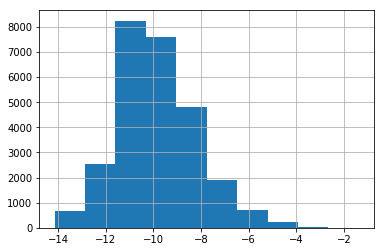

In [372]:
np.log(df['probability']).hist()
plt.show()

In [373]:
final_scores = generate_text(learn, GPU=GPU,
                             seed_text='xbos xbol-1 [verse-1] xeol xbol-2',
                             max_len=50, context_length=200,
                             beam_width=3, verbose=False,
                             temp=1.4, multinomial=True, graph=False, get_probs=False)

100%|██████████| 50/50 [00:29<00:00,  1.08it/s]


In [374]:
#print all of the final options of songs
song, score = final_scores[0]
print_words(song)
print(score)

xbos xbol-1 [verse-1] xeol 
 xbol-2 everything , everything across time xeol 
 xbol-3 everything , everything , everything comes to nothing xeol 
 xbol-4 everything and everything xeol 
 xbol-5 everything is everything xeol 
 xbol-6 xeol 
 xbol-7 [chorus] xeol 
 xbol-8 everything is everything xeol 
 xbol-9 everything is everything xeol 
 xbol-10 everything is everything xeol 
 xbol-11 everything is everything 76.94984640800992


## Multimodal Model (3.4-ULMFiT-MM-108k)

This is where things get a bit trickier...
Modify generate function to work with multimodal modeling

This is the main analysis. We want to see if changing the audio features changes the predicted probabilities

In [8]:
MODEL_PATH = Path(f'../data/models/3.4-ULMFiT-MM-108k')

In [9]:
data_lm = TextLMDataBunch.from_tokens(MODEL_PATH,
                                      bs=128,
                                      max_vocab=10000)

In [10]:
train_text = copy(data_lm.train_ds)
valid_text = copy(data_lm.valid_ds)

#### Audio Data

In [11]:
df_train = pd.read_csv('../data/interim/msd-aggregate/msd-aggregate-train.csv')
df_valid = pd.read_csv('../data/interim/msd-aggregate/msd-aggregate-valid.csv')

#### Define Model

In [12]:
audio_sz = 34
vocab_sz = 10002
emb_sz = 400
n_hid = 1150
n_layers = 3
pad_token = 1
qrnn = False
bidir = False
drop_mult = 0.5
dps = np.array([0.25, 0.1, 0.2, 0.02, 0.15]) * drop_mult
hidden_p = dps[4]
input_p = dps[0]
embed_p = dps[3]
weight_p = dps[2]
tie_weights = True
output_p = dps[1]
bias = True

class MultiModalRNN(RNNCore):
    def __init__(self, audio_sz, output_p, bias, tie_encoder:bool=True, **kwargs):
        super(MultiModalRNN, self).__init__(**kwargs)
        self.rnns = None
        self.audio_sz = audio_sz
        self.multimode = [nn.LSTM(emb_sz + audio_sz if l == 0 else n_hid,
                                  (n_hid if l != n_layers - 1 else emb_sz)//self.ndir,
                                  1, bidirectional=bidir) for l in range(n_layers)]
        self.multimode = [WeightDropout(rnn, weight_p) for rnn in self.multimode]
        self.multimode = torch.nn.ModuleList(self.multimode)
        
        if tie_encoder:
            enc = self.encoder
        else:
            enc = None
        
        self.multidecoder = LinearDecoder(vocab_sz,
                                          emb_sz,
                                          output_p,
                                          tie_encoder=enc,
                                          bias=bias)
        
    def forward(self, input:LongTensor, input_audio:Tensor)->Tuple[Tensor,Tensor,Tensor]:
        sl,bs = input.size()
        if bs!=self.bs:
            self.bs=bs
            self.reset()
        raw_output = self.input_dp(self.encoder_dp(input))
        raw_output = torch.cat([raw_output, input_audio], dim=2)
        new_hidden,raw_outputs,outputs = [],[],[]
        for l, (rnn,hid_dp) in enumerate(zip(self.multimode, self.hidden_dps)):
            raw_output, new_h = rnn(raw_output, self.hidden[l])
            new_hidden.append(new_h)
            raw_outputs.append(raw_output)
            if l != self.n_layers - 1: raw_output = hid_dp(raw_output)
            outputs.append(raw_output)
        self.hidden = to_detach(new_hidden)
        
        output = self.multidecoder.output_dp(outputs[-1])
        decoded = self.multidecoder.decoder(output.view(output.size(0)*output.size(1),
                                                        output.size(2)))
        
        return decoded, raw_outputs, outputs
    
    def _one_hidden(self, l:int)->Tensor:
        "Return one hidden state."
        nh = (self.n_hid if l != self.n_layers - 1 else self.emb_sz)//self.ndir
        return self.weights.new(self.ndir, self.bs, nh).zero_()

    def reset(self):
        "Reset the hidden states."
        [r.reset() for r in self.multimode if hasattr(r, 'reset')]
        self.weights = next(self.parameters()).data
        if self.qrnn: self.hidden = [self._one_hidden(l) for l in range(self.n_layers)]
        else: self.hidden = [(self._one_hidden(l), self._one_hidden(l)) for l in range(self.n_layers)]
    
multimodal_rnn = MultiModalRNN(audio_sz=audio_sz,
                              vocab_sz=vocab_sz,
                              emb_sz=emb_sz,
                              n_hid=n_hid,
                              n_layers=n_layers,
                              pad_token=pad_token,
                              qrnn=qrnn,
                              bidir=bidir,
                              hidden_p=hidden_p,
                              input_p=input_p,
                              embed_p=embed_p,
                              weight_p=weight_p,
                              output_p=output_p,
                              bias=bias,
                              tie_encoder=tie_weights)

multimodal_rnn

MultiModalRNN(
  (encoder): Embedding(10002, 400, padding_idx=1)
  (encoder_dp): EmbeddingDropout(
    (emb): Embedding(10002, 400, padding_idx=1)
  )
  (rnns): None
  (input_dp): RNNDropout()
  (hidden_dps): ModuleList(
    (0): RNNDropout()
    (1): RNNDropout()
    (2): RNNDropout()
  )
  (multimode): ModuleList(
    (0): WeightDropout(
      (module): LSTM(434, 1150)
    )
    (1): WeightDropout(
      (module): LSTM(1150, 1150)
    )
    (2): WeightDropout(
      (module): LSTM(1150, 400)
    )
  )
  (multidecoder): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=10002, bias=True)
    (output_dp): RNNDropout()
  )
)

We don't actually need any of this data, but the current state isn't modular enough to not include it...

One major update we need is to decouple the model with `learner`

#### Feature Engineering
- scikit-learn version 0.20.0 is required!

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer

def log_features(X):
    return np.log(X)
log_feat = FunctionTransformer(log_features, validate=False)

def bin_tempo(X):
    '''
    ref: https://en.wikipedia.org/wiki/Tempo#Italian_tempo_markings
    These are rough loosely based on tempo markings above
    Have considered both classical forms of music and popular
    '''
    assert X.shape[1] == 1, "Only 1 column can be binned"
    bins = [0, 60, 76, 108, 120, 156, 176, 200, 500]
    return pd.DataFrame(pd.cut(X.iloc[:,0], bins=bins))
tempo_feat = FunctionTransformer(bin_tempo, validate=False)

def bin_time_signature(X):
    assert X.shape[1] == 1, "Only 1 column can be binned"
    X['time_signature_bin'] = "Other Signature"
    X.loc[X['time_signature'] == 4, 'time_signature_bin'] = '4/4 Signature'
    X.loc[X['time_signature'] == 3, 'time_signature_bin'] = '3/4 Signature'
    return X[['time_signature_bin']]
time_feat = FunctionTransformer(bin_time_signature, validate=False)

def to_string(X):
    return X.astype('str')

In [14]:
# continous features
numeric_features = ['artist_familiarity',
                    'artist_hotttnesss',
                    'loudness',
                    'song_hotttnesss']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

# log features
log_features = ['duration']
log_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('log_feat', log_feat),
    ('scaler', MinMaxScaler())
])

# categorical features
categorical_features = ['key', 'mode']
categorical_transformer = Pipeline(steps=[
    ('stringify', FunctionTransformer(to_string, validate=False)),
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder())
])

# confidence features
confidence_features = ['key_confidence',
                       'mode_confidence',
                       'time_signature_confidence'
                      ]
confidence_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0))
])

# time signature feature
time_feature = ['time_signature']
time_transformer = Pipeline(steps=[
    ('binner', time_feat),
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('stringify', FunctionTransformer(to_string, validate=False)),
    ('onehot', OneHotEncoder())
])

# tempo feature
tempo_feature = ['tempo']
tempo_transformer = Pipeline(steps=[
    ('binner', tempo_feat),
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('stringify', FunctionTransformer(to_string, validate=False)),
    ('onehot', OneHotEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('log', log_transformer, log_features),
        ('cat', categorical_transformer, categorical_features),
        ('con', confidence_transformer, confidence_features),
        ('time', time_transformer, time_feature),
        ('tempo', tempo_transformer, tempo_feature)
    ],
    remainder='drop'
)

In [15]:
preprocessor.fit(df_train)

/home/syang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)), ('scaler', MinMaxScaler(copy=True, feature_range=(0, 1)))]), ['artist_familiarity', 'artist_hotttnesss', 'loudness', 'song_hotttnes...=<class 'numpy.float64'>, handle_unknown='error',
       n_values=None, sparse=True))]), ['tempo'])])

In [16]:
df_train_tfm = preprocessor.transform(df_train)
df_valid_tfm = preprocessor.transform(df_valid)

train_audio = AudioDataset(df_train_tfm, train_text)
valid_audio = AudioDataset(df_valid_tfm, valid_text)

In [17]:
multi_data = MultimodalDataLoader(audio_dataset=train_audio,
                                  dataset=train_text)
multi_data_valid = MultimodalDataLoader(audio_dataset=valid_audio,
                                  dataset=valid_text)
multi_db = DataBunch(multi_data, multi_data_valid)

In [18]:
learn = RNNLearner(multi_db, multimodal_rnn)

In [19]:
learn.load('3.4-ULMFiT-MM-108k_best')

#### Function to Generate Text For Pure LM

In [20]:
def generate_step(learner, context, audio, context_length, temp=1):

    # FIX THIS
    audio_size = train_audio.feature_size

    model = learner.model
    
    if GPU:
        context = LongTensor(context[-context_length:]).view(-1,1).cuda()
    else:
        context = LongTensor(context[-context_length:]).view(-1,1).cpu()
    
    context = torch.autograd.Variable(context)
    
    model.reset()
    model.eval()
    
    if audio is None:
        audio_features = Tensor([0]*audio_size*len(context))\
        .view(-1, 1, audio_size).cuda()
    else:
        audio_features = np.tile(audio, len(context))
        audio_features = Tensor(audio_features).view(-1, 1, len(audio)).cuda()
        
    # forward pass the "context" into the model
    result, *_ = model(context, audio_features)
    result = result[-1]

    # set unk and pad to 0 prob
    # i.e. never pick unknown or pad
    result[0] = -np.inf
    result[1] = -np.inf

    # softmax and normalize
    probabilities = F.softmax(result/temp, dim=0)
    probabilities = np.asarray(probabilities.detach().cpu(), dtype=np.float)
    probabilities /= np.sum(probabilities) 
    return probabilities

def get_word_from_index(idx):

    return data_lm.valid_ds.vocab.textify([idx])


def print_words(context):
    for i in range(len(context)):
        
        step = context[i]

        word = data_lm.valid_ds.vocab.textify([step])

        if word == 'xeol':
            word = 'xeol \n'
        elif 'xbol' in word:
            word = word
        elif word == 'xeos': 
            print(word)
            break
            
        print(word, end=' ')   

def generate_text(learner, seed_text=['xbos'], audio=None,
                  max_len=500, GPU=False, context_length=20,
                  beam_width=5, temp=1, multinomial=True,
                  verbose=True, graph=False, get_probs=False):
    """Generates text with a given learner and returns best options.

    Parameters
    ----------
    learner : RNNLearner Language Model (RNNLearner.language_model())
        Fastai RNNLearner with tokenized language model data already loaded 
        
    seed_text : list or str
        List of strings where each item is a token. (e.g. ['the', 'cat']) or string that is split on white space

    max_len : int
        Number of words in generated sequence
        
    gpu : bool
        If you're using a GPU or not...
    
    context_length : int
        Amount of words that get input as "context" into the model. Set to 0 for no limit   
        
    beam_width : int
        How many new word indices to try out...computationally expensive
    
    verbose : bool
        If True, prints every possible context for a given word cycle

    Returns
    -------
    context_and_scores : list of lists
        Returns a sorted list of the entire tree search of contexts and their respective scores in the form:
        [[context, score], [context, score], ..., [context, score]]
    """
        
    if isinstance(seed_text, str):
        seed_text = data_lm.train_ds.vocab.numericalize(seed_text.split(' '))
    
    
    # Width for the beam search, to be externalized along with general decoding
    beam_width = beam_width
    
    if graph:
        optimization_graph = Digraph()

    # List of candidate word sequence. We'll maintain #beam_width top sequences here.
    # The context is a list of words, the scores are the sum of the log probabilities of each word
    context_and_scores = [[seed_text, 0.0]]
    
    # Loop over max number of words
    for word_number in tqdm(range(max_len)):
#         print(f'Generating word: {word_number+1} / {max_len}')

        candidates = []
        next_word_probs = []
        
        # For each possible context that we've generated so far, generate new probabilities, 
        # and pick an additional #beam_width next candidates
        for i in range(len(context_and_scores)):
            # Get a new sequence of word indices and log-probability
            # Example: [[2, 138, 661], 23.181717]
            context, score = context_and_scores[i]
            
            # Obtain probabilities for next word given the context 
            probabilities = generate_step(learner, context, audio, context_length, temp)

            # Multinomial draw from the probabilities
            if multinomial:
                multinom_draw = np.random.multinomial(beam_width, probabilities)
                top_probabilities = np.argwhere(multinom_draw != 0).flatten()                    
                
            # top-k from probabilities    
            else:
                top_probabilities = np.argsort(-probabilities)[:beam_width]
                        
            #For each possible new candidate, update the context and scores
            for j in range(len(top_probabilities)):
                next_word_idx = top_probabilities[j]
                new_context = context + [next_word_idx]
                candidate = [new_context, (score - np.log(probabilities[next_word_idx]))]
                candidates.append(candidate)
                
                if get_probs:
                    next_word_prob = probabilities[next_word_idx]
                    potential_next_word = get_word_from_index(next_word_idx)
                    prior_context = [get_word_from_index(w) for w in context]
                    next_word_probs.append((prior_context, potential_next_word, next_word_prob))
                
                if graph:
                    optimization_graph.node("%d_%d" % (word_number, next_word_idx), "%s (%.2f)" % (get_word_from_index(next_word_idx), candidate[1]))
                    optimization_graph.edge("%d_%d" % (word_number - 1, context[len(context) -1]), "%d_%d" % (word_number, next_word_idx))
                
        #update the running tally of context and scores and sort by probability of each entry
        context_and_scores = candidates
        context_and_scores = sorted(context_and_scores, key = lambda x: x[1]) #sort by top entries

        context_and_scores = context_and_scores[:30] #for now, only keep the top 30 to speed things up but we can/should change this to beam_width or something else
        
        if verbose:
            for context, score in context_and_scores:
                print_words(context)
                print('\n')

    if graph:
        now = str(datetime.datetime.now())
        optimization_graph.render(directory='graph_viz/', filename=now, cleanup=True)
        
    if get_probs:
        next_word_probs = sorted(next_word_probs, key=lambda x: -x[2])
        return next_word_probs
        
    return context_and_scores
    

#### Features from validation data

In [21]:
# mode == 1, loudness == -2.3,
# artist_hot == 0.57, artist_familiarity = 0.77, 
# song_hot == n/a
xx = valid_audio[9126]

# mode == 0, loudness == -15.5,
# artist_hot == 0.36, artist_familiarity = 0.51, 
# song_hot == 0
yy = valid_audio[7650]

#### "Artificial" Features

In [151]:
# create artificial audio features
# 0.9 for all continuous features
# key = 0 (of 12)
# mode = 1 (of 2)
# time = 1 (of 3)
# tempo = 7 (of 9)
zz1 = np.array([0.9, 0.9, 0.9, 0.9, 0.9, 
                0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                0., 1.,
                0.9, 0.9, 0.9,
                0., 1., 0.,
                0., 0., 1., 0., 0., 0., 0., 0., 0.
               ])
# 0.2 for all continuous features
# key = 0 (of 12)
# mode = 0 (of 2)
# time = 1 (of 3)
# tempo = 2 (of 9)
zz2 = np.array([0.2, 0.2, 0.2, 0.2, 0.2, 
                1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                0., 1.,
                0.9, 0.9, 0.9,
                0., 1., 0.,
                0., 0., 1., 0., 0., 0., 0., 0., 0.
               ])

##### Feature set #1
These are features that appear to be more "Pop"

In [152]:
next_word_probs = generate_text(learn, GPU=GPU,
                             seed_text='xbos xbol-1 [verse-1] xeol xbol-2',
                             audio=zz1,
                             max_len=10, context_length=200,
                             beam_width=1000, verbose=False,
                             temp=1, multinomial=False, graph=False, get_probs=True)

100%|██████████| 10/10 [00:12<00:00,  1.54s/it]


In [153]:
next_word_probs = [s for s in next_word_probs if s[1] not in stop_words]
next_word_probs = [s for s in next_word_probs if 'xbol' not in s[1]]

In [154]:
df = pd.DataFrame(next_word_probs, columns=['context', 'next_word', 'probability'])

In [155]:
zz1_words = df.groupby('next_word').sum().sort_values(by='probability', ascending=False)
zz1_words.sample(10)

,probability
next_word,
ass,3.430205e-05
stress,1.525948e-06
knockin,1.344053e-09
shone,1.995385e-05
ending,8.662105e-05
clothes,1.212948e-06
clean,1.505122e-04
hip,8.649441e-05
others,2.680671e-04


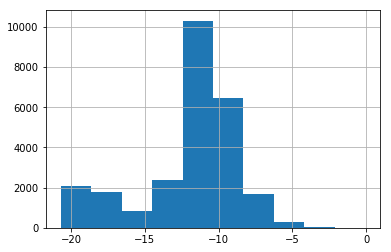

In [156]:
np.log(df['probability']).hist()
plt.show()

In [157]:
# final_scores = generate_text(learn, GPU=GPU,
#                              seed_text='xbos xbol-1 [verse-1] xeol xbol-2',
#                              audio=zz1,
#                              max_len=50, context_length=200,
#                              beam_width=3, verbose=False,
#                              temp=1.4, multinomial=True, graph=False, get_probs=False)

In [158]:
# #print all of the final options of songs
# song, score = final_scores[0]
# print_words(song)
# print(score)

##### Features set #2
These are features that are less "Pop"

In [159]:
next_word_probs = generate_text(learn, GPU=GPU,
                             seed_text='xbos xbol-1 [verse-1] xeol xbol-2',
                             audio=zz2,
                             max_len=10, context_length=200,
                             beam_width=1000, verbose=False,
                             temp=1, multinomial=False, graph=False, get_probs=True)

100%|██████████| 10/10 [00:12<00:00,  1.50s/it]


In [160]:
next_word_probs = [s for s in next_word_probs if s[1] not in stop_words]
next_word_probs = [s for s in next_word_probs if 'xbol' not in s[1]]

In [161]:
df = pd.DataFrame(next_word_probs, columns=['context', 'next_word', 'probability'])

In [162]:
zz2_words = df.groupby('next_word').sum().sort_values(by='probability', ascending=False)
zz2_words.sample(10)

,probability
next_word,
east,0.000095
beneath,0.000462
bush,0.000003
dreamed,0.001942
longest,0.000028
(never,0.000016
wastin,0.000002
dancin,0.000505
wondered,0.000933


In [172]:
df_combined = pd.merge(zz1_words, zz2_words, how='outer', left_index=True, right_index=True)
# df_combined['rel_ratio_abs'] = (df_combined['probability_x'] / df_combined['probability_y'])
df_combined['diff'] = df_combined['probability_x'] - df_combined['probability_y']
df_combined['diff_abs'] = np.abs(df_combined['diff'])
df_combined['rel_diff_abs'] = df_combined['diff_abs'] / df_combined['probability_x']
df_combined.sort_values(by='rel_diff_abs', ascending=False)\
    .loc[df_combined['diff'] > 0, :]

,probability_x,probability_y,diff,diff_abs,rel_diff_abs
next_word,,,,,
24,4.611565e-05,8.816805e-09,4.610683e-05,4.610683e-05,0.999809
pa,2.502828e-05,1.028903e-08,2.501799e-05,2.501799e-05,0.999589
neva,2.635164e-06,1.201998e-09,2.633962e-06,2.633962e-06,0.999544
fever,4.107700e-06,1.402422e-08,4.093676e-06,4.093676e-06,0.996586
hum,2.778501e-06,1.405765e-07,2.637924e-06,2.637924e-06,0.949406
possibly,2.350971e-06,1.436968e-07,2.207274e-06,2.207274e-06,0.938878
seeking,2.685019e-05,1.907542e-06,2.494264e-05,2.494264e-05,0.928956
trippin,1.186395e-05,8.437511e-07,1.102020e-05,1.102020e-05,0.928881
relate,2.965873e-06,2.295046e-07,2.736369e-06,2.736369e-06,0.922618


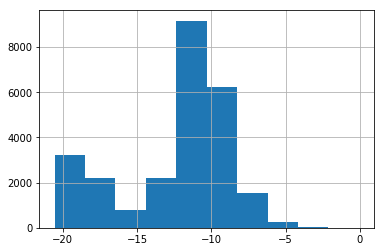

In [590]:
np.log(df['probability']).hist()
plt.show()

In [591]:
final_scores = generate_text(learn, GPU=GPU,
                             seed_text='xbos xbol-1 [verse-1] xeol xbol-2',
                             audio=zz2,
                             max_len=50, context_length=200,
                             beam_width=3, verbose=False,
                             temp=1.4, multinomial=True, graph=False, get_probs=False)

100%|██████████| 50/50 [00:29<00:00,  1.07it/s]


In [592]:
#print all of the final options of songs
song, score = final_scores[0]
print_words(song)
print(score)

xbos xbol-1 [verse-1] xeol 
 xbol-2 here she comes now xeol 
 xbol-3 here she comes now xeol 
 xbol-4 she cries no more xeol 
 xbol-5 here she comes now xeol 
 xbol-6 here she comes xeol 
 xbol-7 xeol 
 xbol-8 [verse-2] xeol 
 xbol-9 here she comes , here she comes xeol 
 xbol-10 here she comes , here she comes 57.72286504894128
